**Importing libraries**

In [3]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

**Data Preperation**

In [4]:


labels = ['glioma', 'meningioma','pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)
print("x_train shape : ",x_train.shape)
print("x_test shape : ",x_test.shape)
print("y_train shape : ",y_train.shape)
print("y_test shape : ",y_test.shape)

100%|██████████| 300/300 [00:01<00:00, 236.21it/s]


x_train shape :  (4117, 200, 200, 3)
x_test shape :  (906, 200, 200, 3)
y_train shape :  (4117,)
y_test shape :  (906,)


In [5]:
pd.Series(y_train).value_counts()

2    1457
1    1339
0    1321
dtype: int64

0


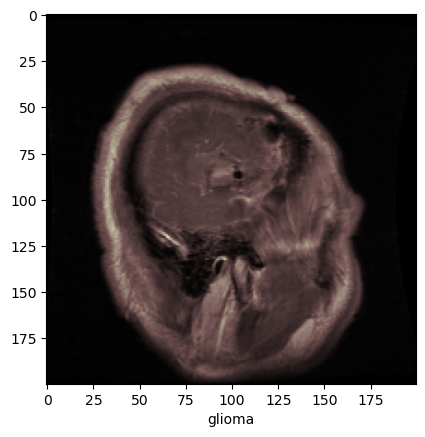

In [6]:
def plot_img(X,y,index):
    plt.imshow(X[index])
    plt.xlabel(labels[y[index]])
    print(y[index])

plot_img(x_train,y_train,0)

In [7]:
x_train, y_train = shuffle(x_train,y_train, random_state=1) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=1) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1236, 200, 200, 3)


In [8]:
# Apply data augmentation to the training data
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.05, height_shift_range=0.05,
                             zoom_range=0.2, horizontal_flip=True)

datagen.fit(x_train)

In [9]:
base_model = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

94765736/94765736 [==============================] - 3s 0us/step


In [10]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

#compile our model.
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


 #Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#Train the model with data augmentation and early stopping
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), steps_per_epoch=len(x_train) // 32, epochs=20,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])

In [11]:
history=model.fit(datagen.flow(x_train, y_train, batch_size=16), epochs=18,
                    validation_data=(x_val, y_val))

Epoch 1/18
181/181 [==============================] - 83s 202ms/step - loss: 0.3216 - accuracy: 0.8737 - val_loss: 1.1336 - val_accuracy: 0.3390
Epoch 2/18
181/181 [==============================] - 32s 179ms/step - loss: 0.1578 - accuracy: 0.9476 - val_loss: 1.3910 - val_accuracy: 0.3430
Epoch 3/18
181/181 [==============================] - 32s 177ms/step - loss: 0.1152 - accuracy: 0.9649 - val_loss: 1.2197 - val_accuracy: 0.4879
Epoch 4/18
181/181 [==============================] - 33s 180ms/step - loss: 0.0831 - accuracy: 0.9688 - val_loss: 0.8727 - val_accuracy: 0.5607
Epoch 5/18
181/181 [==============================] - 33s 180ms/step - loss: 0.0820 - accuracy: 0.9733 - val_loss: 0.4958 - val_accuracy: 0.8180
Epoch 6/18
181/181 [==============================] - 32s 177ms/step - loss: 0.0746 - accuracy: 0.9771 - val_loss: 0.4420 - val_accuracy: 0.8390
Epoch 7/18
181/181 [==============================] - 34s 190ms/step - loss: 0.0706 - accuracy: 0.9757 - val_loss: 0.0843 - val_ac

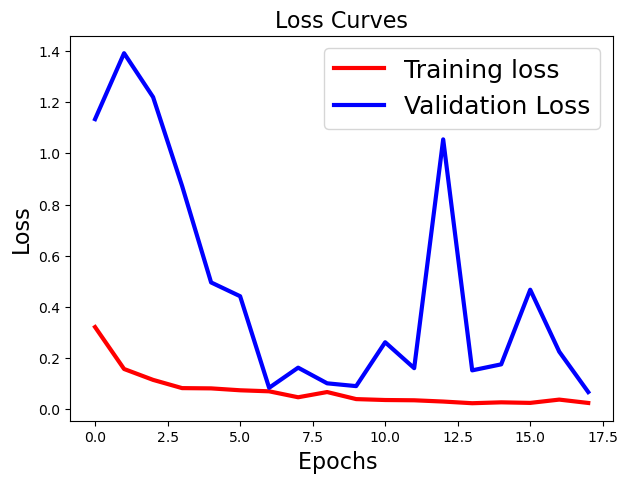

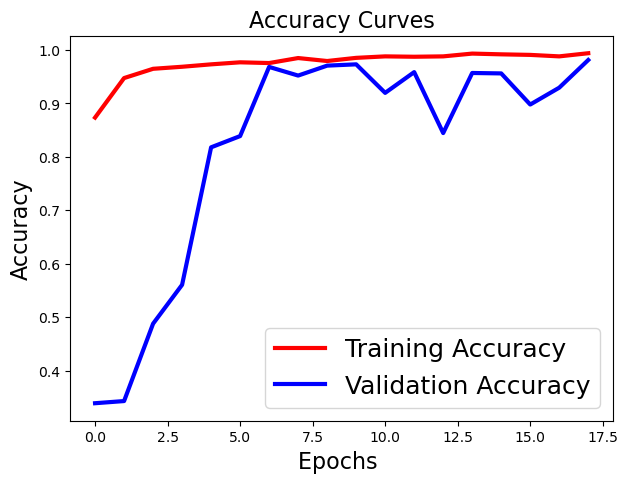

In [12]:
#Plot the Loss Curves
plt.figure(figsize=[7,5])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[7,5])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

29/29 [==============================] - 2s 67ms/step - loss: 0.0613 - accuracy: 0.9845
Test Loss: 0.06130416691303253
Test Accuracy: 0.9845474362373352


29/29 [==============================] - 2s 49ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       300
           1       0.99      0.97      0.98       306
           2       0.97      1.00      0.99       300

    accuracy                           0.98       906
   macro avg       0.98      0.98      0.98       906
weighted avg       0.98      0.98      0.98       906



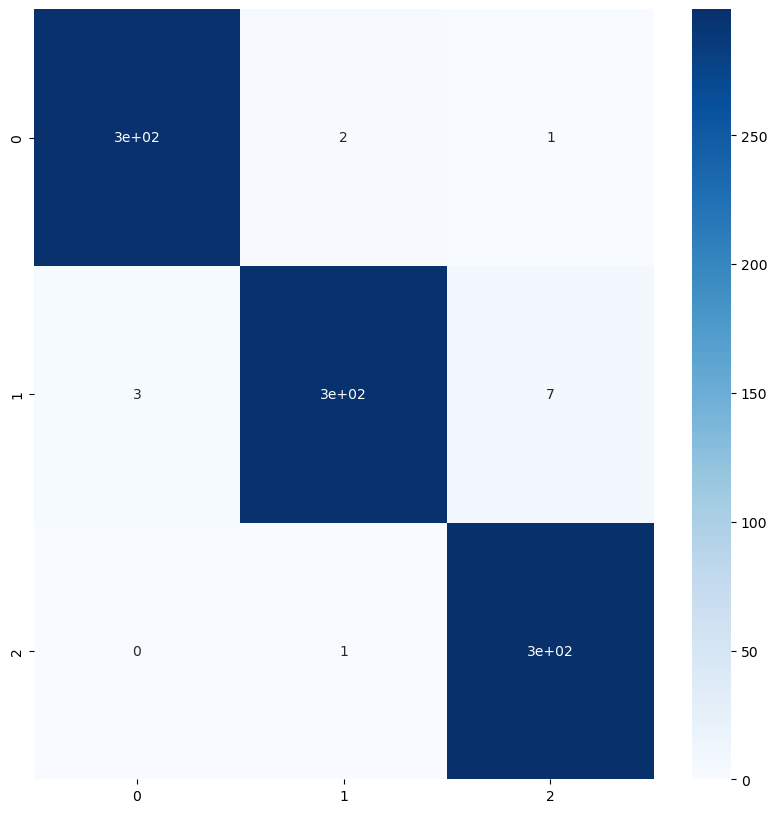

In [14]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [15]:
model.save('model_ResNet.h5')